In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [44]:
df = pd.read_csv('train.csv')

In [45]:
df = df.dropna(subset=['value_eur'])

In [ ]:
df['is_goalkeeper'] = (df["player_positions"].str.contains("GK")).astype(int)

In [46]:
# date columns 
start_date = float(2021) # year when dataset was recorded 
df["years_left_contract"] = df["club_contract_valid_until"] - start_date

df['club_joined'] = pd.to_datetime(df['club_joined'], format='%Y-%m-%d')
df["years_in_club"] = start_date - df["club_joined"].dt.year

df[["work_attack", "work_defense"]] = df["work_rate"].str.split("/", expand=True)
maps = {"Low": 1, "Medium": 2, "High": 3}
df["work_attack"] = df["work_attack"].map(maps)
df["work_defense"] = df["work_defense"].map(maps)

In [58]:
categorical_cols = ['league_name', 'club_name', 'nationality_name', 'preferred_foot', 'club_position', 'player_positions', 'body_type']
for col in categorical_cols:
    df[col] = pd.Categorical(df[col]).codes  # turns categories into integer codes

In [56]:
drop_cols = ['club_contract_valid_until', 'long_name', 'short_name', 'Unnamed: 0', 'id', 'dob', 'work_rate', 'club_joined', 'player_tags', 'player_traits', 'club_loaned_from', 'nation_position']
df = df.drop(columns=drop_cols, errors='ignore')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15333 entries, 0 to 15390
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_positions             15333 non-null  int16  
 1   overall                      15333 non-null  int64  
 2   potential                    15333 non-null  int64  
 3   value_eur                    15333 non-null  float64
 4   wage_eur                     15333 non-null  float64
 5   age                          15333 non-null  int64  
 6   height_cm                    15333 non-null  int64  
 7   weight_kg                    15333 non-null  int64  
 8   club_team_id                 15333 non-null  float64
 9   club_name                    15333 non-null  int16  
 10  league_name                  15333 non-null  int8   
 11  league_level                 15333 non-null  float64
 12  club_position                15333 non-null  int8   
 13  club_jersey_number   

In [68]:
y = df['value_eur']
X = df.drop(columns=['value_eur'])

In [69]:
# --- 8. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 9. XGBoost DMatrix (optional but better memory) ---
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [74]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'seed': 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=100000,
    evals=[(dtrain, 'train')],
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-rmse:6902500.67491
[1]	train-rmse:6258648.03511
[2]	train-rmse:5678486.38522
[3]	train-rmse:5153150.68113
[4]	train-rmse:4681493.15660
[5]	train-rmse:4259516.48572
[6]	train-rmse:3877485.96526
[7]	train-rmse:3531250.76537
[8]	train-rmse:3219096.36897
[9]	train-rmse:2935774.63738
[10]	train-rmse:2679752.91998
[11]	train-rmse:2448265.49454
[12]	train-rmse:2240789.69200
[13]	train-rmse:2051173.46456
[14]	train-rmse:1880256.22551
[15]	train-rmse:1725552.23226
[16]	train-rmse:1584507.22846
[17]	train-rmse:1455795.36073
[18]	train-rmse:1338000.60377
[19]	train-rmse:1231617.48655
[20]	train-rmse:1134350.26142
[21]	train-rmse:1046536.11913
[22]	train-rmse:964680.22642
[23]	train-rmse:890876.01132
[24]	train-rmse:823991.74735
[25]	train-rmse:763319.40906
[26]	train-rmse:708653.79489
[27]	train-rmse:661617.03465
[28]	train-rmse:616868.40672
[29]	train-rmse:575688.97620
[30]	train-rmse:539058.93369
[31]	train-rmse:504957.22626
[32]	train-rmse:475449.67988
[33]	train-rmse:448407.29384
[3

RMSE: 923520.6183217436


<Figure size 1000x800 with 0 Axes>

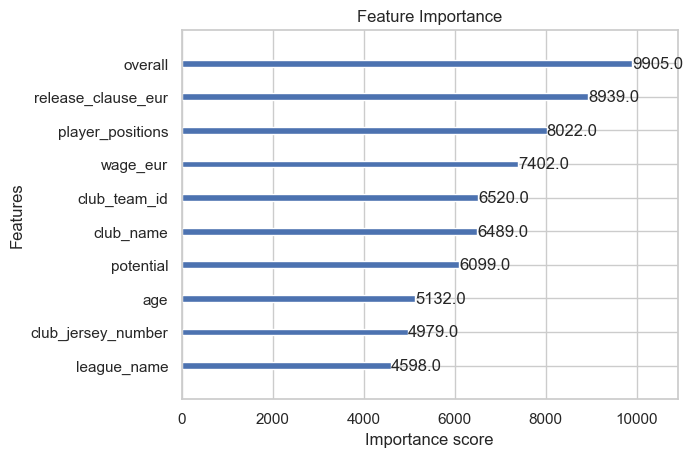

In [77]:
# --- 10. Predictions ---
y_pred = model.predict(dtest)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")

# --- 11. Feature importance ---
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()
